# Imports

In [1]:
import pandas as pd
import os, sys

sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '..')))

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [5]:
data_dir = "/Users/andrew/Desktop/Harvard/idreos-research/gpu_profiling/data/bandwidth/a100.csv"
orig_df = pd.read_csv(data_dir)
orig_df

,dtype,Size,Time
0,b16,256,0.016384
1,16,256,0.016384
2,32,256,0.016384
3,b16,1280,0.016384
4,16,1280,0.016384
...,...,...,...
187,16,63744,188.986877
188,32,63744,377.800186
189,b16,64768,195.372543
190,16,64768,195.457535


In [6]:
dtype_to_bytes = {
    "b16": 2,
    "16": 2,
    "32": 4
}

orig_df["GFLOPs"] = orig_df.apply(lambda row: (row["Size"] ** 2) * dtype_to_bytes[row["dtype"]] / 1e9, axis=1)
orig_df

,dtype,Size,Time,GFLOPs
0,b16,256,0.016384,0.000131
1,16,256,0.016384,0.000131
2,32,256,0.016384,0.000262
3,b16,1280,0.016384,0.003277
4,16,1280,0.016384,0.003277
...,...,...,...,...
187,16,63744,188.986877,8.126595
188,32,63744,377.800186,16.253190
189,b16,64768,195.372543,8.389788
190,16,64768,195.457535,8.389788


In [32]:
# temp = orig_df[orig_df["Time"].str.startswith("CUDA out of memory.")].reset_index()
# temp

In [7]:
# temp["GFLOPs"].hist(bins=30)

In [8]:
# temp.loc[1, "Time"]

<AxesSubplot:>

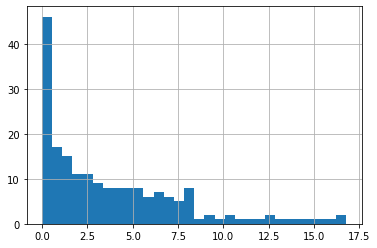

In [10]:
# df = orig_df[~orig_df["Time"].str.startswith("CUDA out of memory.")].reset_index()
df = orig_df
df["Time"] = df["Time"].astype(float)
df["GFLOPsPerMs"] = df["GFLOPs"] / df["Time"]
df["GFLOPs"].hist(bins=30)

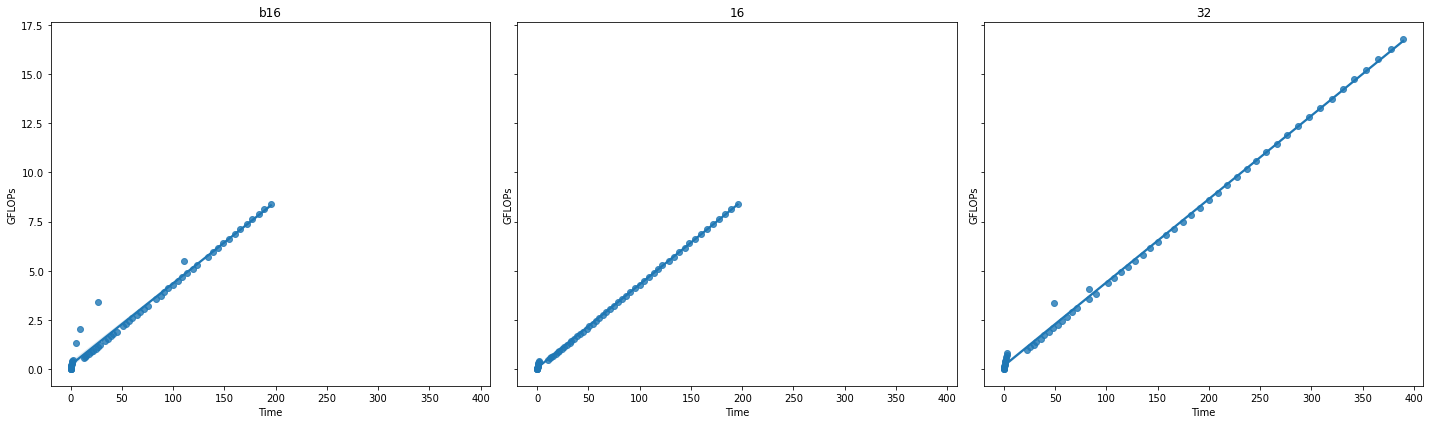

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(dtype_to_bytes.keys()):
    ax = axes[idx]
    sns.regplot(x="Time", y="GFLOPs", data=df.query(f"dtype == '{dtype}'"), ax=ax)
    ax.set_title(dtype)

plt.tight_layout()
plt.show()

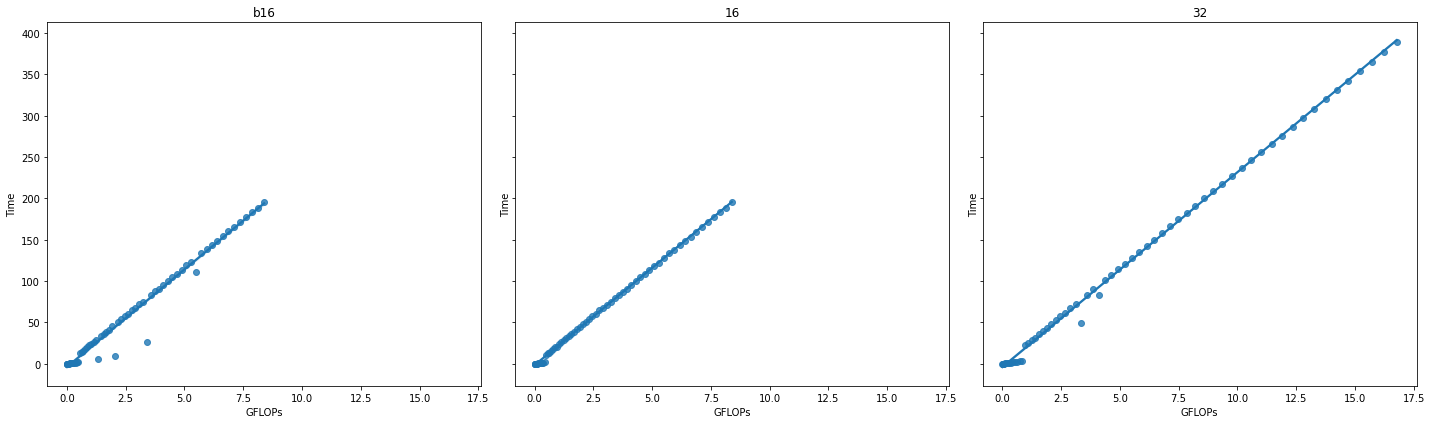

In [8]:
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(dtype_to_bytes.keys()):
    ax = axes[idx]
    sns.regplot(x="GFLOPs", y="Time", data=df.query(f"dtype == '{dtype}'"), ax=ax)
    ax.set_title(dtype)

plt.tight_layout()
plt.show()

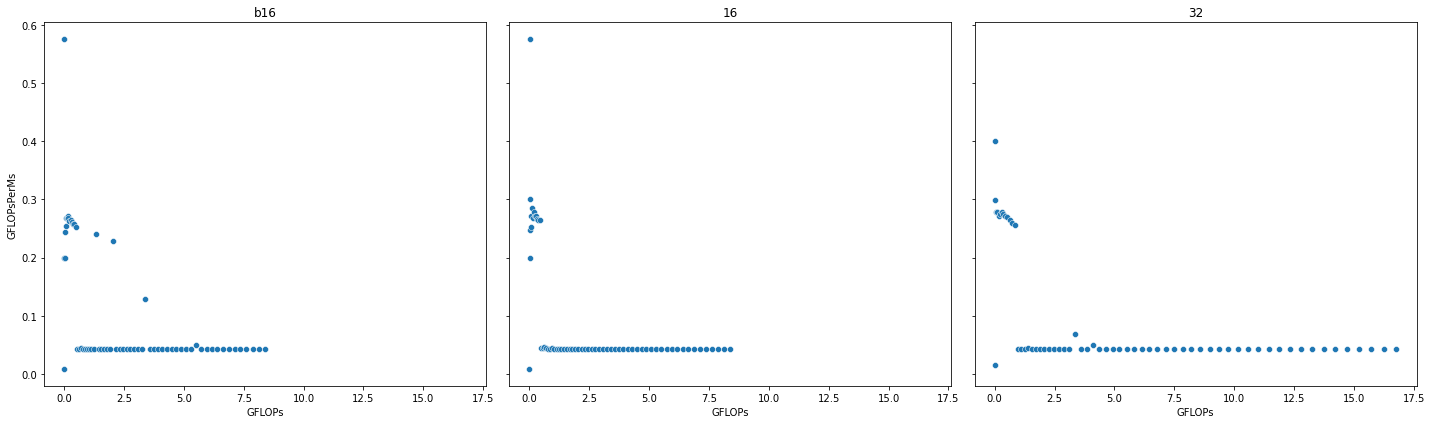

In [13]:
# This graph might not make sense.
fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(dtype_to_bytes.keys()):
    ax = axes[idx]
    sns.scatterplot(x="GFLOPs", y="GFLOPsPerMs", data=df.query(f"dtype == '{dtype}'"), ax=ax)
    ax.set_title(dtype)

plt.tight_layout()
plt.show()

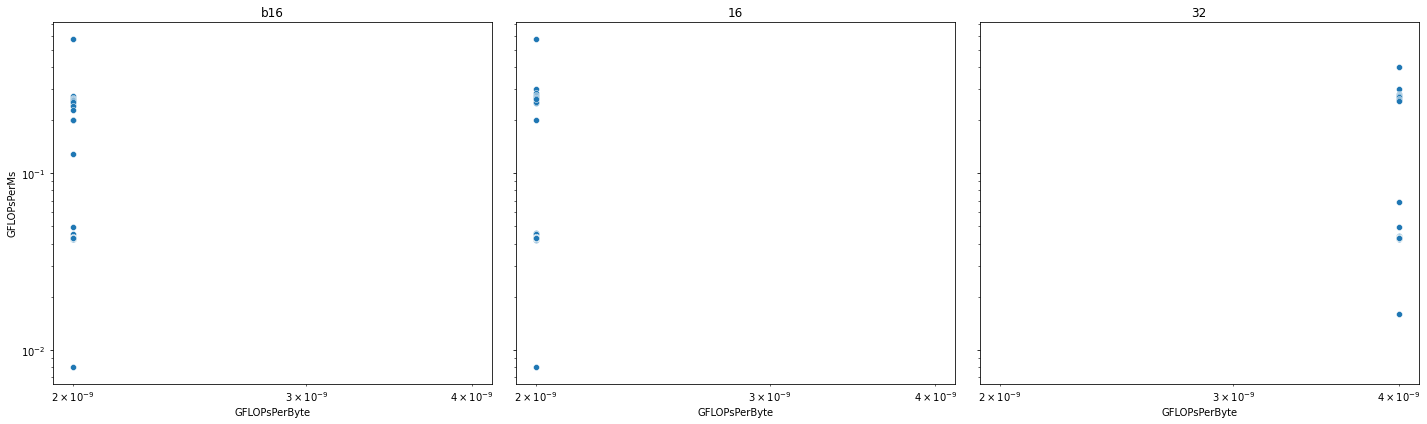

In [15]:
"""
Idt this graph makes sense. Specifically:
1) FLOPs and memory accesses are theoretically the same here.
2) Arithmetic intensity := flops / memory accesses = c \in \R.
3) Therefore, no relationship since arithmetic intensity not increasing. 
"""

df["GFLOPsPerByte"] = df["GFLOPs"] / ((df["Size"] ** 2))

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharex=True, sharey=True)
axes = axes.flatten()

for idx, dtype in enumerate(dtype_to_bytes.keys()):
    ax = axes[idx]
    sns.scatterplot(x="GFLOPsPerByte", y="GFLOPsPerMs", data=df.query(f"dtype == '{dtype}'"), ax=ax)
    ax.set_title(dtype)

ax.set_xscale("log")
ax.set_yscale("log")
plt.tight_layout()
plt.show()

In [26]:
import statsmodels.api as sm
model = sm.OLS(df["GFLOPs"], df["Time"])
results = model.fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                 GFLOPs   R-squared (uncentered):                   0.997
Model:                            OLS   Adj. R-squared (uncentered):              0.997
Method:                 Least Squares   F-statistic:                          7.439e+04
Date:                Sat, 17 Aug 2024   Prob (F-statistic):                   1.84e-249
Time:                        13:38:39   Log-Likelihood:                         -22.620
No. Observations:                 192   AIC:                                      47.24
Df Residuals:                     191   BIC:                                      50.50
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Time           0.0431      0.000    272.746      0.000       0.043       0.043
==============================================================================
Omnibus:                      239.029   Durbin-Watson:                   1.712
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             9702.196
Skew:                           5.250   Prob(JB):                         0.00
Kurtosis:                      36.204   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

<Axes: >

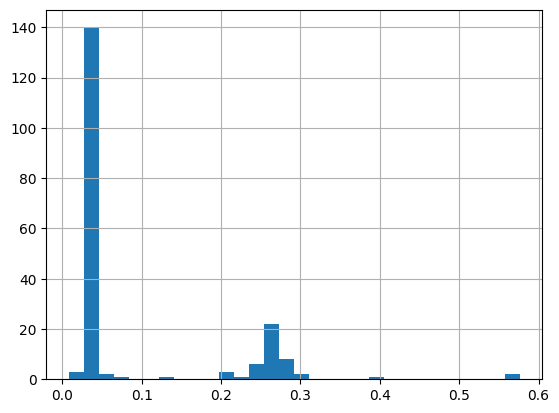

In [17]:
(df["GFLOPs"] / df["Time"]).hist(bins=30)

In [ ]:
"""
0.043 GFLOPs/ms => 43 GFLOPs/s.

Might be max? Seems sus...

"""